In [1]:
from ast import literal_eval
import numpy as np
from atmos_cloud_sim_uj_utils import show_plot
from matplotlib import pyplot
from joblib import Parallel, delayed, parallel_backend

In [2]:
import os
os.environ["NUMBA_NUM_THREADS"] = "1"

In [49]:
from PySDM.physics import si
from PySDM.initialisation import discretise_multiplicities, equilibrate_wet_radii
from PySDM.initialisation.spectra import Lognormal, Sum
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity
from PySDM.backends import CPU
from PySDM.dynamics import AmbientThermodynamics, Condensation
from PySDM.environments import Parcel
from PySDM import Builder, Formulae, products as PySDM_products

In [6]:
kappa_1 = .53

In [50]:
products = (PySDM_products.WaterMixingRatio(unit = "g/kg", name = "ql"), 
            PySDM_products.PeakSupersaturation(name = "S max"),                                                                                                                          
            PySDM_products.RipeningRate(name = "Ripe Rate"), 
            PySDM_products.DeactivatingRate(name = "Deact Rate"), 
            PySDM_products.ActivatingRate(name = "Act Rate"), 
            PySDM_products.ParcelDisplacement(name = "z"))

In [71]:
def run(**args):
    env = Parcel(
        dt = 1 * si.s,
        mass_of_dry_air = 1e3 * si.kg,
        p0 = 1000 * si.hPa,
        q0 = 20 * si.g / si.kg,
        T0 = args["T0"],
        w = .5 * si.m / si.s
    )
    modes = {
        kappa_1: Lognormal(norm_factor = 100.0 / si.mg, m_mode = 50.0 * si.nm,  s_geom = 2.0),          # TODO: resolve issue with units and get to 1/cm^3
        .4: Lognormal(norm_factor = args["norm_factor_2"], m_mode = 50.0 * si.nm, s_geom = 2.0)
    }
    cloud_range = (.5 * si.um, 25 * si.um)
    n_steps = 5000
    n_sd_per_mode = 50
    
    n_sd = len(modes) * n_sd_per_mode
    builder = Builder(backend=CPU(), n_sd=n_sd)
    builder.set_environment(env)
    builder.add_dynamic(AmbientThermodynamics())
    builder.add_dynamic(Condensation())

    attributes = {
        attr: np.empty(n_sd) for attr in (
            'volume', 'n', 'dry volume', 'kappa times dry volume'
        )
    }
    for mode, (kappa, spectrum) in enumerate(modes.items()):
        r_dry, specific_concentration = ConstantMultiplicity(spectrum).sample(n_sd_per_mode)
        v_dry = builder.formulae.trivia.volume(radius=r_dry)
        r_wet = equilibrate_wet_radii(r_dry, env, kappa * v_dry)

        chunk = slice(mode * n_sd_per_mode, (mode+1) * n_sd_per_mode)
        attributes['n'][chunk] = specific_concentration * env.mass_of_dry_air
        attributes['dry volume'][chunk] = v_dry
        attributes['kappa times dry volume'][chunk] = kappa * v_dry
        attributes['volume'][chunk] = builder.formulae.trivia.volume(radius=r_wet)

    r_bins_edges = np.linspace(0 * si.nm, 4e3 * si.nm, 101, endpoint=True)

    particulator = builder.build(attributes, products=products)
    
    # particulator.run(steps=n_steps)
    # cell_id = 0
    output = {product.name: [product.get().copy()] for product in particulator.products.values()}

    for step in range(n_steps):
        particulator.run(steps=1)
        for product in particulator.products.values():
            output[product.name].append(product.get().copy())
    
    final_values = {}
    for attr in ('kappa', 'n', 'critical volume', 'volume', 'critical supersaturation'):
        final_values[attr] = particulator.attributes[attr].to_ndarray()
    
    
    activated_fraction_a = {}
    activated_fraction_b = {}
    error_estimate = {}
    for kappa in modes.keys():
        within_mode = final_values['kappa'] == kappa
        sum_multiplicity = np.sum(np.where(
                within_mode,
                final_values['n'],
                0
            ))
        activated_fraction_a[kappa] = (
            np.sum(np.where(
                np.logical_and(final_values['volume'] > final_values['critical volume'], within_mode),
                final_values['n'],
                0
            ))
            / 
            sum_multiplicity 

        )
        activated_fraction_b[kappa] = (
            np.sum(np.where(
                np.logical_and(final_values['critical supersaturation'] < np.amax(output['S max']), within_mode),
                final_values['n'],
                0
            ))
            / 
            sum_multiplicity    
        )
        max_multiplicity = np.amax(particulator.attributes["n"].to_ndarray())
        error_estimate[kappa] = max_multiplicity/sum_multiplicity
        np.sum(np.where(
                within_mode,
                final_values['n'],
                0
            ))
    
    return (str(args), {"activated fraction b": activated_fraction_b, "error estimate": error_estimate, "output": output, "activated fraction a": activated_fraction_a})

In [72]:
data = Parallel(verbose=10, n_jobs=-1)(
    delayed(run)(**{'norm_factor_2': norm_factor_2, 'T0': T0})
        for norm_factor_2 in np.linspace(100, 5000/si.mg, 5)
        for T0 in (300 * si.K,)
)
data = dict(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [58]:
N_2_obs = [18.74716810149539, 110.41572270049846, 416.00589034889026, 918.1014952424102, 1914.816492976891, 4919.913910285455]
N_act_obs = [0.7926937018577255, 0.7161078386950611, 0.5953670140462167, 0.4850589034888989, 0.34446080652469424, 0.162630267331219]
N_2_paper_param = [54.6839601268689, 72.69483461712753, 109.48119619392855, 127.7469415496148, 155.44290892614436, 183.2238332578163,
                   220.2650657000454, 275.8269143633893, 312.86814680561884, 368.5999093792484, 433.50702310829183, 554.4007702763934,
                   628.9080199365658, 693.9850475758949, 740.5414589941097, 787.0129134571821, 852.3448119619393, 917.4218396012684,
                   973.3235160851837, 1047.915722700498, 1103.8173991844137, 1178.2396918894428, 1234.1413683733576,1280.7827367467153,
                   1364.5502945174449,1467.1782963298592,1513.734707748075, 1560.2911191662893, 1709.5604893520617, 1765.547122791119,
                   1849.4845944721342, 1989.408699592207, 2092.0367014046215, 2157.3685999093796, 2222.7004984141367, 2297.292705029451,
                   2353.364295423651, 2456.07725419121, 2549.2750339827826, 2605.26166742184, 2689.199139102854, 2810.6026280018123,
                   2997.3380154055285, 3099.8810602628, 3221.2845491617572, 3314.6522428636154, 3389.2444494789315, 3463.9216130493887,
                   3566.634571816946, 3650.657000453103, 3762.5453103760756, 3827.9621658359765, 3911.814680561849, 3995.922066153149,
                   4126.585863162664, 4247.904395106479, 4322.496601721793, 4397.258722247395, 4490.54145899411, 4574.563887630267,
                   4667.9315813321255, 4835.891481649297]
N_act_paper_param = [0.7307884005437245, 0.7016538287267784, 0.676110104213865, 0.657884005437245, 0.643271409152696, 0.6322949705482556,
                     0.6176597190756684, 0.5957068418667876, 0.5810715903942004, 0.5663910285455369, 0.5444154961486181, 0.5186678749433621,
                     0.5075781603987314, 0.49287494336202997, 0.48548935206162214, 0.4744676030811056, 0.47067285908473044, 0.45596964204802903,
                     0.4485613955595833, 0.4411078386950612, 0.43369959220661536, 0.41897371998187594, 0.4115654734934301, 0.4078160398731311,
                     0.39306751246035343, 0.3855459900317173, 0.37816039873130947, 0.37077480743090174, 0.3595038513819666, 0.3557317625736294,
                     0.3482555505210695, 0.33700724966017237, 0.32948572723153613, 0.325690983235161, 0.32189623923878585, 0.31444268237426376,
                     0.31430675124603535, 0.31042138649750806, 0.2992863615768011, 0.2955142727684641, 0.2880380607159041, 0.28410738559130055,
                     0.27638196647032176, 0.265224286361577, 0.2612936112369735, 0.25743090167648397, 0.249977344811962, 0.24615994562754873,
                     0.24227458087902143, 0.23843452650657015, 0.22725419120978696, 0.22709560489352065, 0.21598323516085194, 0.21577933846850939,
                     0.2081898504757591, 0.20062301767104684, 0.19316946080652464, 0.19298821930222032, 0.1854893520616221, 0.18164929768917082,
                     0.17778658812868153, 0.16647032170367027]

In [68]:

norm_factor_2 = [literal_eval(key)['norm_factor_2'] for key in data.keys()]
args_common = {"yerr" : [val["error estimate"][kappa_1] for val in data.values()], "fmt" : 'o'}
pyplot.errorbar(
    norm_factor_2,
    [np.nanmax(val["activated fraction_a"][kappa_1]) for val in data.values()], 
    **args_common
)
pyplot.errorbar(
    norm_factor_2,
    [np.nanmax(val["activated fraction_b"][kappa_1]) for val in data.values()], 
    **args_common
)
pyplot.plot(np.array(N_2_paper_param) / si.cm**3, N_act_paper_param)
pyplot.ylabel('Mode 1 Number Fraction Activated')
pyplot.xlabel('Mode 2 Aerosol Number (TODO)')
show_plot("fig_1.pdf")

KeyError: 'activated fraction_a'

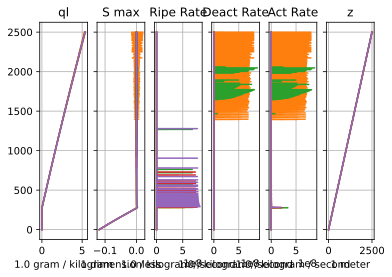

HTML(value="<a href='.\\parcel.pdf' target='_blank'>.\\parcel.pdf</a><br>")

In [64]:

product_names = [product.name for product in products]
fig, axs = pyplot.subplots(1, len(product_names), sharey="all")
for i, product in enumerate(products):
    if product.name in product_names:
        for val in data.values():
            output = val['output']
            axs[i].plot(output[product.name], output['z'])
        axs[i].set_title(product.name)
        axs[i].set_xlabel(product.unit)
        axs[i].grid()
    elif product.name == "z":
        axs[0].set_ylabel(product.unit)
show_plot('parcel.pdf')

In [37]:
output.keys()

dict_keys(['water mixing ratio', 'peak supersaturation', 'ripening rate', 'deactivating rate', 'activating rate'])

## Old Code 

In [78]:
# def run(**args):
#     env = Parcel(
#         dt = .1 * si.s,
#         mass_of_dry_air = 1e3 * si.kg,
#         p0 = 1000 * si.hPa,
#         q0 = 20 * si.g / si.kg,
#         T0 = args["T0"],    
#         w = 0.5 * si.m / si.s
#     )
#     kappa = .53 * si.dimensionless # value from kappa kohler
#     cloud_range = (.5 * si.um, 25 * si.um)
#     output_interval = 10
#     output_points = 40
#     n_sd = 100

#     builder = Builder(backend=CPU(), n_sd=n_sd)
#     builder.set_environment(env)
#     builder.add_dynamic(AmbientThermodynamics())
#     builder.add_dynamic(Condensation())

#     mode_1 = Lognormal(norm_factor = 1e4 / si.mg, m_mode = 50.0 * si.nm,  s_geom = 2.0) # TODO: determine if 1/cm^3 can be done instead of 1/mg
#     mode_2 = Lognormal(norm_factor = 2e3 / si.mg, m_mode = 60.0 * si.nm, s_geom = 2.0)  # TODO: allow for same dry radius in each mode; make norm_factor input function argument input
#     r_dry, specific_concentration = spectral_sampling.Logarithmic(
#                 spectrum= Sum((mode_1, mode_2)),
#                 size_range=(10.0 * si.nm, 500.0 * si.nm)
#             ).sample(n_sd)                                                              # TODO: externally mix modes
#     v_dry = builder.formulae.trivia.volume(radius=r_dry)
#     r_wet = equilibrate_wet_radii(r_dry, env, kappa * v_dry)

#     attributes = {
#         'n': discretise_multiplicities(specific_concentration * env.mass_of_dry_air),
#         'dry volume': v_dry,
#         'kappa times dry volume': kappa * v_dry,
#         'volume': builder.formulae.trivia.volume(radius=r_wet)
#     }

#     r_bins_edges = np.linspace(0 * si.nm, 4e3 * si.nm, 101, endpoint=True)
#     particulator = builder.build(attributes, products=[
#         products.PeakSupersaturation(),
#         products.EffectiveRadius(radius_range=cloud_range),
#         products.ParticleConcentration(radius_range=cloud_range),
#         products.WaterMixingRatio(radius_range=cloud_range),
#         products.ActivatingRate(),
#         products.DeactivatingRate(),
#         products.ParcelDisplacement(),
#         products.ParticleSizeSpectrumPerVolume(radius_bins_edges=r_bins_edges, name="Particles Wet Size Spectrum"),
#         # products.AmbientTemperature(),
#         # products.AmbientPressure()                                                    # TODO: Get temperature and pressure in outputs
#     ])

#     cell_id = 0
#     output = {product.name: [product.get().copy()] for product in particulator.products.values()}

#     for step in range(output_points):
#         particulator.run(steps=output_interval)
#         for product in particulator.products.values():
#             output[product.name].append(product.get().copy())
#     # print(output['S_max'])

#     # def getList(dict):
#     #     return dict.keys()

#     # print(getList(output))
#     # print('-------')
#     # print(output['T_env'])
#     # fig, axs = pyplot.subplots(1, 6, sharey="all")
#     # for i, (key, product) in enumerate(particulator.products.items()):
#     #     if key in ["S_max", "r_eff", "n_c_cm3", "ql", "activating_rate", "deactivating_rate"]:
#     #         axs[i].plot(output[key], output['z'], marker='.')
#     #         axs[i].set_title(product.name)
#     #         axs[i].set_xlabel(product.unit)
#     #         axs[i].grid()
#     # axs[0].set_ylabel(particulator.products['z'].unit)
#     # pyplot.savefig('parcel.svg')

#     r_bins_values = np.array(output["Particles Wet Size Spectrum"]) / env.mass_of_dry_air



# # fig, ax = pyplot.subplots(1, 1, sharex=True)
# # pyplot.step(x=r_bins_edges[:-1] / si.um, y=r_bins_values[0], where='post', label="init")
# # pyplot.step(x=r_bins_edges[:-1] / si.um, y=r_bins_values[-1], where='post', label="end")
# # pyplot.xscale('log')
# # pyplot.yscale("log")
# # ax.legend(loc='best')
# # ax.grid()
# # pyplot.tight_layout()
# # ax.set_title('Wet radius size distribution')
# # ax.set_xlabel("wet radius [um]")
# # ax.set_ylabel("dN/dlog_10(r) [1/mg 1/um]")
# # fig.subplots_adjust(top=0.88)
# # pyplot.legend()
# # pyplot.savefig('parcel_size_distr.svg')

#     return (str(args), output)

In [79]:
# # with parallel_backend('threading', n_jobs=-2):
# with parallel_backend("loky", n_jobs=1):
#     data = Parallel(verbose=10)(
#         delayed(run)(**{'p0': p0, 'T0': T0})
#             for p0 in (1122 * si.hPa, 1133 * si.hPa)
#             for T0 in (300 * si.K, 303 * si.K)
#     )
# data = dict(data)

In [80]:
# # with parallel_backend('threading', n_jobs=-2):
# with parallel_backend("loky", n_jobs=1):
#     data = Parallel(verbose=10)(
#         delayed(run)(**{'p0': p0, 'T0': T0, 'norm_factor_mode2': norm_factor})
#             for p0 in (1122 * si.hPa, 1133 * si.hPa)
#             for T0 in (300 * si.K, 303 * si.K)
#             for norm_factor in ()
#     )
# data = dict(data)

In [ ]:
# Notes:

##### setting both modes with m_mode = 50.0 (same dry radius, radius from fig 1 in ARG 2000) yields exception error:
######### ERROR: Exception: 1.0565392508872784% error in total real-droplet number due to sampling
######### Concern: ARG paper has same dry radius for each mode with differing particle concentrations (norm_factor)

##### T0, p0 set to just below/above ARG fig 1 to (hopefully) have the same ambient T, p at saturation 
######### Still unsure if this is a good strat, talked about putting saturation conditions from PySDM into Parametrization code
######### Concern: strategy in bullet before is not condusive to replicating paper results

##### key error when adding AmbientTemperature and AmbientPressure products
######### ERROR: KeyError: None
######### Concern: when I ctrl+click on the products, I can find these outputs under ambient_thermodynamics, so not sure why I can't use them

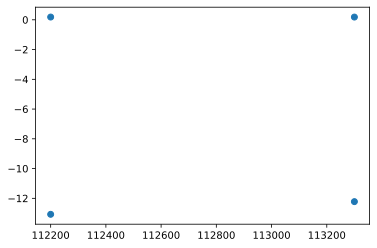

HTML(value="<a href='.\\fig_1.pdf' target='_blank'>.\\fig_1.pdf</a><br>")

In [ ]:
# pyplot.scatter(
#     [literal_eval(key)['p0'] for key in data.keys()],
#     [np.nanmax(val['S_max']) for val in data.values()]
# )
# show_plot("fig_1.pdf")